# Model 200 basicVs coupled steady state solution

This notebook is for the EMS paper. It will have a model200 landscape (stream power with variable source area hydrology) at steady state. There will be two outputs from this notebook: 1) a NetCDF file of the topography, which we will use to make an oblique Paraview image of the landscape, and 2) a slope-area plot at steady state.

Importantly, this will be one of the "user-friendly" notebooks that get submitted along with the EMS paper.

#### Charlie working on

In [1]:
from erosion_model import BasicVs
import numpy as np
import matplotlib.pyplot as plt
from landlab import imshow_grid

//anaconda/lib/python2.7/site-packages/xarray/core/formatting.py:16: FutureWarning: The pandas.tslib module is deprecated and will be removed in a future version.
  from pandas.tslib import OutOfBoundsDatetime


In [2]:
#parameter dictionary (diffusivity will be 0, K_sp is nonzero)
params = { 'number_of_node_rows' : 100,
          'number_of_node_columns' : 160,
          'node_spacing' : 10.0,
          'east_boundary_closed' : False,
          'north_boundary_closed' : False,
          'west_boundary_closed' : False,
          'south_boundary_closed' : False,
          'dt' : 10.0,
          'K_sp' : 0.001,
          'm_sp' : 0.5,
          'n_sp' : 1.0,
          'linear_diffusivity' : 0.1,
          'outlet_lowering_rate' : 0.0005,
          'output_filename': 'model_000_output',
          'recharge_rate': 0.01,
          'initial_soil_thickness' : 1.0,
          'K_hydraulic_conductivity' : 15.
}

In [3]:
#instantiate and establish topo error tolerance
vs = BasicVs(params=params)
tolerance = 0.0001

In [4]:
#time loop
dt = 10
elapsed_time = 0 #years
keep_running = True
while keep_running == True:
    pre_topo = vs.grid.at_node['topographic__elevation'][vs.grid.core_nodes]
    vs.run_one_step(dt)
    post_topo = vs.grid.at_node['topographic__elevation'][vs.grid.core_nodes]
    if elapsed_time % 1000 == 0:
        print elapsed_time
        print 'MAX: ', max(abs(pre_topo - post_topo))
        print 'MEAN: ', np.average(abs(pre_topo - post_topo))
    elapsed_time += dt
    if max(abs(pre_topo - post_topo)) <= tolerance: #1mm
        keep_running = False

0
MAX:  0.111624096593
MEAN:  0.00489213765307
1000
MAX:  0.0116473313919
MEAN:  0.00438970019222
2000
MAX:  0.00937821245055
MEAN:  0.00414758865047
3000
MAX:  0.00641941934267
MEAN:  0.00393342256829
4000
MAX:  0.00789758486527
MEAN:  0.00375283590599
5000
MAX:  0.0096207535748
MEAN:  0.00358730208126
6000
MAX:  0.00603537285739
MEAN:  0.00344265292772
7000
MAX:  0.00627823526038
MEAN:  0.00333036466518
8000
MAX:  0.00690074099023
MEAN:  0.00323786819444
9000
MAX:  0.00682671861048
MEAN:  0.00316074790683
10000
MAX:  0.00795597362341
MEAN:  0.00308755933305
11000
MAX:  0.00732436493241
MEAN:  0.00301987406061
12000
MAX:  0.00801767005023
MEAN:  0.00295520790126
13000
MAX:  0.00782903194931
MEAN:  0.00289452189397
14000
MAX:  0.00917793106859
MEAN:  0.00283746803234
15000
MAX:  0.00874575527726
MEAN:  0.0027825840018
16000
MAX:  0.0078612637435
MEAN:  0.00273205695385
17000
MAX:  0.00978824078063
MEAN:  0.00268536676029
18000
MAX:  0.00946064833198
MEAN:  0.0026400493119
19000
MAX:  0

KeyboardInterrupt: 

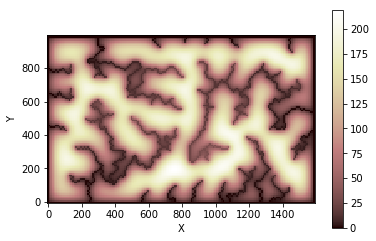

In [5]:
%matplotlib inline
imshow_grid(vs.grid, 'topographic__elevation')

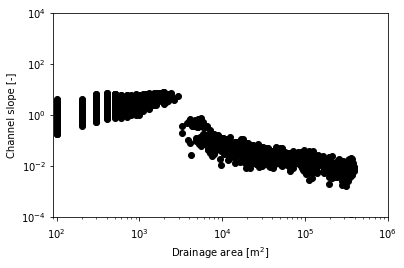

In [6]:
###MAKE SLOPE-AREA PLOT

import matplotlib

#assign area_array and slope_array
area_array = vs.grid.at_node['drainage_area'][(vs.grid.node_x > 10)&(vs.grid.node_x < 1580)&(vs.grid.node_y >10)&(vs.grid.node_y<980)]
slope_array = vs.grid.at_node['topographic__steepest_slope'][(vs.grid.node_x > 10)&(vs.grid.node_x < 1580)&(vs.grid.node_y >10)&(vs.grid.node_y<980)]

##instantiate figure and plot
fig = plt.figure(figsize=(6, 3.75))
slope_area = plt.subplot()

#plotting param
matplotlib.rcParams.update({'font.size': 20})

#create an array for the detachment-limited analytical solution
u = 0.0005 #m/yr, uplift or baselevel lowering rate
k = 0.001 #fluvial erodibility
m = 0.5 #discharge exponent
n = 1.0 #slope exponent

#calculate analytical slope from area field
analytical_slope_array = np.power((u / k), 1 / n) * np.power(area_array, -m/n)

#plot the slope predicted by the effective area
#slope_by_aeff = (0.0005 / 0.001) * np.power(vs.eff_area, -0.5)
#plt.scatter(vs.grid.at_node['drainage_area'][(vs.grid.node_x > 10)&(vs.grid.node_x < 1580)&(vs.grid.node_y >10)&(vs.grid.node_y<980)], 
#            slope_by_aeff[(vs.grid.node_x > 10)&(vs.grid.node_x < 1580)&(vs.grid.node_y >10)&(vs.grid.node_y<980)],
#           label = 'VSA solution',
#           marker='o', edgecolor='0', color='1')

#plot the data
slope_area.scatter(area_array, slope_array, marker='o', c='k', 
                   label = 'VSA + diffusion solution') #plot HA data


#plot the analytical solution
#slope_area.plot(area_array, analytical_slope_array, linestyle='-',
#                color='grey', linewidth = 1, label = 'Basic solution')

#make axes log and set limits
slope_area.set_xscale('log')
slope_area.set_yscale('log')

slope_area.set_xlim(9*10**1, 1*10**6)
slope_area.set_ylim(1e-4, 1e4)

#set x and y labels
slope_area.set_xlabel(r'Drainage area [m$^2$]')
slope_area.set_ylabel('Channel slope [-]')
#slope_area.legend(scatterpoints=1,prop={'size':12})
slope_area.tick_params(axis='x', which='major', pad=7)

fig.savefig('maintext_vsa_slope_area.eps',bbox_inches='tight', dpi=1000) #save figure

In [7]:
#export NetCDF for Paraview image of topography
from landlab.io.netcdf import write_netcdf
write_netcdf('maintext_vsa.nc', vs.grid, format='NETCDF3_64BIT', names='topographic__elevation')